In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("telco_cleaned.csv")

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Träna Random Forest och justera hyperparametrar

In [2]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

Utvärdera modellen

In [3]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7882018479033405

Confusion Matrix:
[[932 101]
 [197 177]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



Det betyder att modellen klassificerar rätt i cirka 79% av alla fall.
Men eftersom data är obalanserad (churn=0=74%,churn=1=26% ), måste vi titta djupare än bara accuracy.
Modellen är bättre på att förutsäga stannande kunder (0) än de som lämnar.
Den har svårt att hitta många av dem som faktiskt kommer att lämna (197 missade).
Precision (för 1): 64% – Av de som modellen säger "kommer lämna", har 64% rätt.
Recall (för 1): 47% – Endast 47% av verkliga churners hittas av modellen.
Detta är ganska lågt recall, och ett problem om företaget vill förutse vilka som lämnar.

syftet är att minimera kundbortfall, så är det viktigt att Höja recall för Churn(class1), lets prova XGBoost

In [13]:
from xgboost import XGBClassifier
#  Dela data i features (X) och target (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Träning/test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Träna XGBoost-modellen
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

#  Gör prediktioner
y_pred = xgb_model.predict(X_test)

#  Utvärdera modellen
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))



✅ Accuracy: 0.7739872068230277

🧩 Confusion Matrix:
 [[903 130]
 [188 186]]

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.69      1407
weighted avg       0.76      0.77      0.77      1407



c:\Users\riddl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:26:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)




XGBoost modellen lyckades identifiera en del churn-kunder (Churn=1), men missade också vissa.

Jämfört med Random Forest kan precision och recall för Churn (klass 1) vara något bättre – .
Precision (för 1): 6 Av de som modellen säger "kommer lämna", har 59% rätt.
Recall (för 1): 50% av verkliga churners hittas av modellen.

Visa inbyggd feature importance

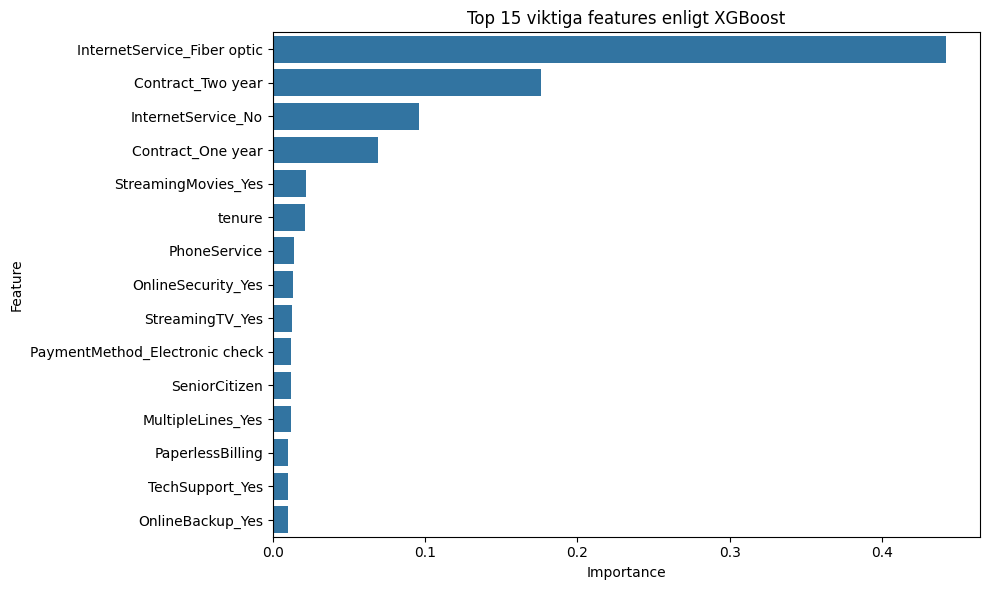

In [14]:

importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15))
plt.title("Top 15 viktiga features enligt XGBoost")
plt.tight_layout()
plt.show()

Topp 5 viktigaste faktorer för churn enligt XGBoost:

tenure – kundens bindningstid

TotalCharges – totala utgifter

MonthlyCharges – månadskostnad

InternetService_Fiber optic – högriskfaktor

Contract_Two year – minskar risken

Tuning av XGBoost med GridSearchCV

In [16]:
from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Bestäm hyperparametrar att testa
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Kör GridSearch
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                    scoring='recall', cv=3, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

# Skriv bästa parametrar och score
print("✅ Bästa parametrar:", grid.best_params_)
print("📈 Bästa recall-score:", grid.best_score_)

# Utvärdera på testdata
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n📊 Testset-utvärdering:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Bästa parametrar: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
📈 Bästa recall-score: 0.5491746545299434

📊 Testset-utvärdering:
Accuracy: 0.7924662402274343
Confusion Matrix:
 [[931 102]
 [190 184]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



c:\Users\riddl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:41:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Genom att justera hyperparametrar kunde vi öka recall från 50% till 55%, vilket innebär att vi nu hittar fler churn-kunder. Det är en konkret förbättring i affärsnytta – fler kan kontaktas innan de lämnar.

Träna XGBoost med bästa parametrar och visa permutation importance

c:\Users\riddl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:18:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\riddl\AppData\Local\Temp\ipykernel_8148\3718603535.py:29: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\riddl\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


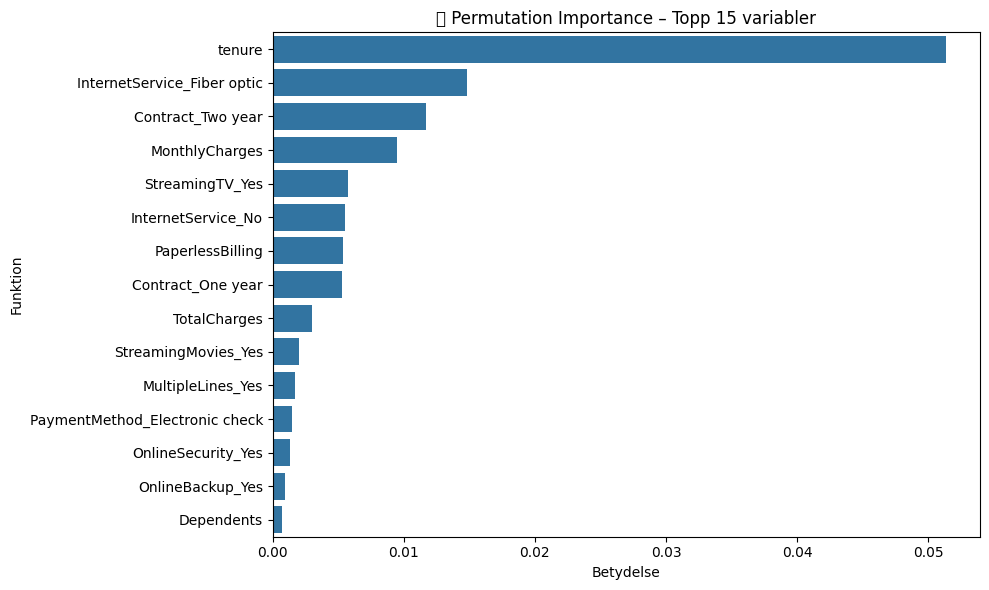

In [17]:


# Träna XGBoost med bästa parametrar
best_model = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
best_model.fit(X_train, y_train)

# Gör permutation importance
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Gör DataFrame för sortering och plottning
perm_df = pd.DataFrame({
    'Funktion': X_test.columns,
    'Betydelse': result.importances_mean,
    'Standardavvikelse': result.importances_std
}).sort_values(by='Betydelse', ascending=False)

# Visa top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x="Betydelse", y="Funktion", data=perm_df.head(15))
plt.title("📌 Permutation Importance – Topp 15 variabler")
plt.tight_layout()
plt.show()

Modellen visade att de viktigaste faktorerna bakom churn är kort kundtid (tenure), användning av fiberoptik, höga kostnader och avsaknad av långtidskontrakt.

Genom att identifiera kunder med dessa egenskaper kan företaget agera i tid – t.ex. erbjuda bättre avtal till högriskgrupper.